###Import Library yang dibutuhkan

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
#split library
from sklearn.model_selection import train_test_split

#tensorflow library
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

###Dataset Movie Genre

#### Menggunakan dataset movie genre dari kaggle
https://www.kaggle.com/lokkagle/movie-genre-data

In [2]:
df = pd.read_csv('/content/kaggle_movie_train.csv')
df

,id,text,genre
0,0,"eady dead, maybe even wishing he was. INT. 2ND...",thriller
1,2,"t, summa cum laude and all. And I'm about to l...",comedy
2,3,"up Come, I have a surprise.... She takes him ...",drama
3,4,ded by the two detectives. INT. JEFF'S APARTME...,thriller
4,5,"nd dismounts, just as the other children reach...",drama
...,...,...,...
22574,28161,n in the world to decide what I'm going to do ...,drama
22575,28162,shards. BOJO LAZ! Laz pushes Deke back through...,drama
22576,28163,"OTTIE You've got a thing about Ernie's, haven'...",thriller
22577,28165,....with marked skill and dexterity . LANA wry...,action


In [3]:
df['genre'].value_counts()

drama        8873
thriller     6824
comedy       2941
action       2392
sci-fi        613
horror        456
other         270
adventure     147
romance        63
Name: genre, dtype: int64

Memilih 4 Genre sebagai label

In [4]:
df = df[~df['genre'].isin(['drama','thriller','other','adventure','romance'])]
df['genre'].value_counts()

comedy    2941
action    2392
sci-fi     613
horror     456
Name: genre, dtype: int64

### Data Processing

In [5]:
df['Text'] = df['text'].map(lambda x: re.sub(r'\W+', ' ', x))
# drop kolom id dan text lama
df = df.drop(['id', 'text'], axis=1)
df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,genre,Text
1,comedy,t summa cum laude and all And I m about to lau...
9,action,e reels as the world spins Sweat pours off him...
20,comedy,I say he s a man who ll go far Some people sa...
25,comedy,you find out where the bachelor party is COLE ...
29,comedy,ibly horrendous public break up on the quad Ag...


In [6]:
genre = pd.get_dummies(df.genre)
df_genre = pd.concat([df, genre], axis=1)
df_genre = df_genre.drop(columns='genre')
df_genre.head()

,Text,action,comedy,horror,sci-fi
1,t summa cum laude and all And I m about to lau...,0,1,0,0
9,e reels as the world spins Sweat pours off him...,1,0,0,0
20,I say he s a man who ll go far Some people sa...,0,1,0,0
25,you find out where the bachelor party is COLE ...,0,1,0,0
29,ibly horrendous public break up on the quad Ag...,0,1,0,0


In [7]:
text = df_genre['Text'].astype(str)
label = df_genre[['action', 'comedy','horror','sci-fi']].values

###Tokenizer and Modelling

split data untuk train dan test dengan 20% test_size

In [8]:
genre_train, genre_test, label_train, label_test = train_test_split(text, label, test_size = 0.2)

In [9]:
tokenizer = Tokenizer(num_words=5000, oov_token='x')
tokenizer.fit_on_texts(genre_train)
tokenizer.fit_on_texts(genre_test)

In [10]:
seq_train = tokenizer.texts_to_sequences(genre_train)
seq_test = tokenizer.texts_to_sequences(genre_test)

In [11]:
pad_train = pad_sequences(seq_train)
pad_test = pad_sequences(seq_test)

membuat model NLP

In [12]:
from tensorflow.keras.optimizers import Adam

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=5000, output_dim=16),
    tf.keras.layers.LSTM(64),
    # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(128, activation='relu'),
    # tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4, activation='softmax'),
])

Adam(learning_rate=0.00256, name='Adam')
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [13]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          80000     
_________________________________________________________________
lstm (LSTM)                  (None, 64)                20736     
_________________________________________________________________
dense (Dense)                (None, 128)               8320      
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 516       
Total params: 109,572
Trainable params: 109,572
Non-trainable params: 0
_________________________________________________________________
None


In [14]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
      if(logs.get('accuracy')>0.925 and logs.get('val_accuracy')>0.9):
        print("\nAkurasi telah mencapai >92.5%! dan validasi akurasi >90%")
        self.model.stop_training = True
callbacks = myCallback()

In [18]:
num_epochs=30
history = model.fit(pad_train, label_train, epochs=num_epochs,
                    validation_data=(pad_test, label_test), verbose=2, callbacks=[callbacks])

Epoch 1/30
161/161 - 22s - loss: 1.0735e-04 - accuracy: 1.0000 - val_loss: 0.9698 - val_accuracy: 0.8907
Epoch 2/30
161/161 - 22s - loss: 0.2227 - accuracy: 0.9256 - val_loss: 0.8158 - val_accuracy: 0.8158
Epoch 3/30
161/161 - 22s - loss: 0.0643 - accuracy: 0.9772 - val_loss: 0.5964 - val_accuracy: 0.8540
Epoch 4/30
161/161 - 22s - loss: 0.0386 - accuracy: 0.9904 - val_loss: 0.6158 - val_accuracy: 0.8759
Epoch 5/30
161/161 - 22s - loss: 0.0168 - accuracy: 0.9953 - val_loss: 0.6934 - val_accuracy: 0.8689
Epoch 6/30
161/161 - 22s - loss: 0.0110 - accuracy: 0.9975 - val_loss: 0.8152 - val_accuracy: 0.8899
Epoch 7/30
161/161 - 22s - loss: 0.0144 - accuracy: 0.9967 - val_loss: 0.7133 - val_accuracy: 0.8728
Epoch 8/30
161/161 - 22s - loss: 0.0107 - accuracy: 0.9975 - val_loss: 0.8025 - val_accuracy: 0.8743
Epoch 9/30
161/161 - 22s - loss: 0.0032 - accuracy: 0.9988 - val_loss: 0.8073 - val_accuracy: 0.8759
Epoch 10/30
161/161 - 22s - loss: 0.0916 - accuracy: 0.9744 - val_loss: 1.0045 - val_ac

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

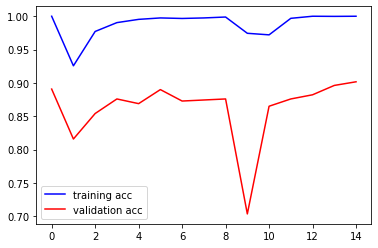

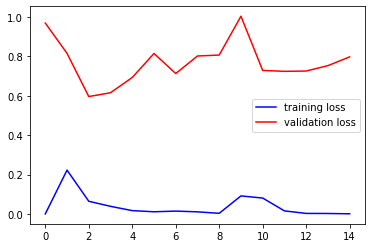

In [20]:
epochs = range(len(acc))

plt.plot(epochs, acc,'b',label='training acc')
plt.plot(epochs, val_acc, 'r', label='validation acc')
plt.legend()
plt.show()


plt.plot(epochs, loss,'b',label='training loss')
plt.plot(epochs, val_loss, 'r', label='validation loss')
plt.legend()
plt.show()